In [1]:
import carla
import random
import math
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
from bird_view_manager import BirdviewSensor
import matplotlib.pyplot as plt
from agents.navigation.global_route_planner import GlobalRoutePlanner
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from chauffeurnet import ObsManager
from carla_gym.core.task_actor.common.criteria import blocked, collision, outside_route_lane, route_deviation, run_stop_sign
from carla_gym.core.task_actor.common.criteria import encounter_light, run_red_light

from agents.navigation.local_planner import LocalPlanner, RoadOption
from agents.navigation.global_route_planner import GlobalRoutePlanner
from agents.tools.misc import (get_speed, is_within_distance,
                               get_trafficlight_trigger_location,
                               compute_distance)

pygame 2.1.2 (SDL 2.0.16, Python 3.7.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [25]:
# Connect to the client and retrieve the world object
client = carla.Client('localhost', 2000)
world = client.get_world()
client.load_world('Town01')

In [26]:
ego_bp = world.get_blueprint_library().find('vehicle.dodge.charger_2020')
ego_bp.set_attribute('role_name','ego')

In [27]:
def follow_vehicle(client, vehicle, offset=carla.Location(x=-6, z=2), pitch=-15):
    spectator = world.get_spectator()
    transform = vehicle.get_transform()
    location = transform.location + transform.get_forward_vector() * offset.x + carla.Location(z=offset.z)
    rotation = carla.Rotation(pitch=pitch, yaw=transform.rotation.yaw + 0, roll=0)
    spectator.set_transform(carla.Transform(location, rotation))
    
class CustomAgent(BasicAgent):
    def __init__(self, vehicle, route_plan, debug=False):
        """
        :param vehicle: actor to apply to local planner logic onto
        :param target_speed: speed (in Km/h) at which the vehicle will move
        """
        super().__init__(vehicle, debug)
        self.vehicle=vehicle
        self.criteria_blocked = blocked.Blocked()
        self.criteria_collision = collision.Collision(self.vehicle, world)
        self.criteria_light = run_red_light.RunRedLight(self._map)
        self.criteria_encounter_light = encounter_light.EncounterLight()
        self.criteria_stop = run_stop_sign.RunStopSign(world)
        self.criteria_outside_route_lane = outside_route_lane.OutsideRouteLane(self._map, self.vehicle.get_location())
        self.criteria_route_deviation = route_deviation.RouteDeviation()
        self.route_plan = route_plan

    def run_step(self):
        """Execute one step of navigation."""
        # RETURN CONTROL
        control = carla.VehicleControl()
        control.steer = 0.0
        control.throttle = 1.0
        control.brake = 0.0
        control.hand_brake = False
        return control

In [28]:
amap = world.get_map()
sampling_resolution = 2
grp = GlobalRoutePlanner(amap, sampling_resolution)
spawn_points = world.get_map().get_spawn_points()
point_a, point_b = random.sample(spawn_points, 2)
a = carla.Location(point_a.location)
b = carla.Location(point_b.location)
w1 = grp.trace_route(a, b) # there are other funcations can be used to generate a route in GlobalRoutePlanner.
i = 0
for w in w1:
    if i % 10 == 0:
        world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
        color=carla.Color(r=255, g=0, b=0), life_time=120.0,
        persistent_lines=True)
    else:
        world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
        color = carla.Color(r=0, g=0, b=255), life_time=1000.0,
        persistent_lines=True)
    i += 1

In [29]:
ego_transform = point_a
ego_vehicle = world.spawn_actor(ego_bp,ego_transform)
print('Ego is spawned')

Ego is spawned


In [30]:
follow_vehicle(client, ego_vehicle)

In [31]:
myAgent = CustomAgent(vehicle=ego_vehicle, route_plan=w1)
destination = point_b.location
myAgent.set_destination(destination)
myAgent.ignore_traffic_lights(active=True)

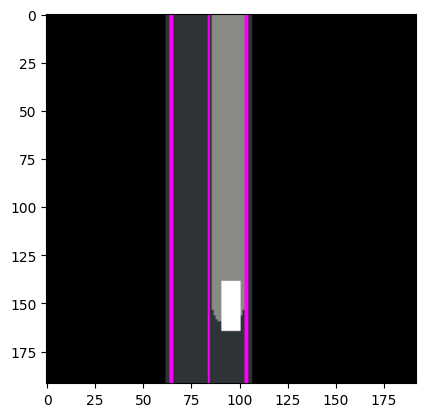

In [32]:
obs_config = {
    "width_in_pixels": 192,
    "pixels_ev_to_bottom": 40,
    "pixels_per_meter": 5.0,
    "history_idx": [-16, -11, -6, -1],
    "scale_bbox": False,
    "scale_mask_col": 1.1
}
bev = ObsManager(obs_config)
bev.attach_ego_vehicle(myAgent)
obs = bev.get_observation()
plt.imshow(obs['rendered'])
plt.show()

In [ ]:
while True:
    if myAgent.done():
        print("The target has been reached, stopping the simulation")
        break
    ego_vehicle.apply_control(myAgent.run_step())
    follow_vehicle(client, ego_vehicle)
    obs = bev.get_observation()
    plt.imshow(obs['rendered'])
    plt.show()

In [ ]:
class MotionPlanningEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self):
        super().__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(
            low=0, 
            high=255,
            shape=(N_CHANNELS, HEIGHT, WIDTH), 
            dtype=np.uint8
       )